In [ ]:
pip install seaborn

In [ ]:
pip install openpyxl

In [44]:
import pandas as pd
import prophet as Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import itertools
import warnings

In [4]:
file_path = "C:/Users/JuCha/OneDrive/Documents/3Master's Classes/IN599 Capstone DA/online_retail_II.xlsx"
uk_retail = pd.read_excel(file_path, sheet_name=None)

In [5]:
sheet_09 = pd.read_excel(file_path, sheet_name=0)
sheet_10 = pd.read_excel(file_path, sheet_name=1)
sheet_11 = pd.read_excel(file_path, sheet_name=2)

In [ ]:
sheet_09.head(10)
sheet_10.head(10)
sheet_11.head(10)

In [ ]:
sheet_10.head(10)

In [ ]:
sheet_11.head(10)

In [ ]:
uk_retail.describe()

In [ ]:
# Initialize an empty dictionary to hold the describe() output for each sheet
descriptions = {}

# Loop through each sheet and apply describe(), storing the result in the descriptions dictionary
for sheet_name, df in uk_retail.items():
    descriptions[sheet_name] = df.describe()

# Now `descriptions` contains describe() output for each sheet
# Example: printing describe() for each sheet
for sheet_name, desc in descriptions.items():
    print(f"Description for {sheet_name}:")
    print(desc)
    print("\n")


In [ ]:
yearly_data = {}

# Loop through each sheet, cleaning and storing relevant data
for sheet_name, df in uk_retail.items():
    # Ensure relevant columns exist
    if 'Quantity' in df.columns and 'Price' in df.columns:
        # Drop any missing or irrelevant data
        df_cleaned = df.dropna(subset=['Quantity', 'Price'])
        
        # If the dataframe is empty after cleaning, skip it
        if df_cleaned.empty:
            print(f"Skipping sheet {sheet_name}: No valid data after cleaning.")
            continue
        
        # Create a Sales column (Quantity * UnitPrice)
        df_cleaned['Sales'] = df_cleaned['Quantity'] * df_cleaned['Price']
        
        # Store the cleaned dataframe
        yearly_data[sheet_name] = df_cleaned[['Quantity', 'Sales']]
    else:
        print(f"Skipping sheet {sheet_name}: Missing required columns.")

# Check if yearly_data has valid dataframes
if len(yearly_data) == 0:
    raise ValueError("No valid sheets with 'Quantity' and 'Price' found.")

# Merge the yearly dataframes by appending rows, adding a year identifier
combined_data = pd.concat(yearly_data, axis=0, keys=yearly_data.keys())

# Reset the index to make the year (sheet name) a column
combined_data.reset_index(level=0, inplace=True)

# Pivot the data so that each year becomes a column for correlation analysis
pivot_data = combined_data.pivot_table(index=combined_data.index, columns='level_0', values=['Quantity', 'Sales'])

# Perform correlation analysis between the years for both Quantity and Sales
quantity_correlation = pivot_data['Quantity'].corr()
sales_correlation = pivot_data['Sales'].corr()

# Output the correlation matrices
print("Correlation matrix for Quantity between years:")
print(quantity_correlation)

print("\nCorrelation matrix for Sales between years:")
print(sales_correlation)

In [ ]:
import seaborn as sns

color_palette = "RdYlGn"

# Heatmap for Quantity Correlation
plt.subplot(1, 2, 1)
sns.heatmap(quantity_correlation, annot=True, cmap=color_palette, center=0, cbar_kws={'label': 'Correlation Coefficient'}, linewidths=0.5, linecolor='white')
plt.title("Quantity Correlation Between Years", fontsize=10)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Year", fontsize=12)

# Heatmap for Sales Correlation
plt.subplot(1, 2, 2)
sns.heatmap(sales_correlation, annot=True, cmap=color_palette, center=0, cbar_kws={'label': 'Correlation Coefficient'}, linewidths=0.5, linecolor='white')
plt.title("Sales Correlation Between Years", fontsize=10)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Year", fontsize=12)

# Adjust layout for better spacing
plt.tight_layout(pad=3)

# Display the heatmaps
plt.show()

In [ ]:
# Calculate total quantity and revenue for each product
top_products = combined_data.groupby(['StockCode', 'Description']).agg(
    total_quantity_sold=('Quantity', 'sum'),
    total_revenue=('Price', lambda x: (x * combined_data.loc[x.index, 'Quantity']).sum())
).reset_index()

# Sort by total quantity sold and total revenue
top_products_by_sales = top_products.sort_values(by='total_quantity_sold', ascending=False).head(10)
top_products_by_revenue = top_products.sort_values(by='total_revenue', ascending=False).head(10)

# Display the top products by sales and revenue
print("Top Products by Sales Volume:")
print(top_products_by_sales)

print("\nTop Products by Revenue:")
print(top_products_by_revenue)

In [ ]:
import pandas as pd

# Load the Excel file
excel_data = pd.ExcelFile(file_path)

# Initialize an empty list to hold each sheet's data with an additional year column
data_frames = []

# Loop through each sheet and load it with an additional 'Year' column
for sheet_name in excel_data.sheet_names:
    # Load the sheet into a DataFrame
    df = pd.read_excel(excel_data, sheet_name=sheet_name)
    
    # Extract the year from the sheet name (if the name is a year like '2009', '2010', etc.)
    df['Year'] = sheet_name
    
    # Append the DataFrame to the list
    data_frames.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_data = pd.concat(data_frames, ignore_index=True)

# Display the combined data
print("Combined Data:")
print(combined_data.head())

In [ ]:
# Create a DataFrame
top_products_df = pd.DataFrame(top_products_by_sales)

# Set the plot style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_products_df, 
    y="Description", 
    x="total_quantity_sold", 
    palette="viridis"
)

# Add data labels to each bar
for index, value in enumerate(top_products_df['total_quantity_sold']):
    plt.text(value, index,  f'{int(value):,}', va='center')  # Adding commas to numbers

# Set plot labels and title
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")
plt.title("Top Products by Sales Volume")

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Create a DataFrame
top_product_df = pd.DataFrame(top_products_by_revenue)

# Set the plot style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_product_df, 
    y="Description", 
    x="total_revenue", 
    palette="husl"
)

# Add data labels to each bar
for index, value in enumerate(top_product_df['total_revenue']):
    plt.text(value, index,  f'{int(value):,}', va='center')  # Adding commas to numbers

# Set plot labels and title
plt.xlabel("Total Revenue")
plt.ylabel("Product Description")
plt.title("Top Products by Revenue")

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
from datetime import timedelta

# Define the snapshot date as one day after the last transaction date in the data
snapshot_date = combined_data['InvoiceDate'].max() + timedelta(days=1)

# Calculate Recency, Frequency, and Monetary metrics for each customer
rfm = combined_data.groupby('Customer ID').agg(
    recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    frequency=('Invoice', 'nunique'),
    monetary=('Price', lambda x: (x * combined_data.loc[x.index, 'Quantity']).sum())
).reset_index()

# Display the RFM table
print("Customer RFM Segmentation:")
print(rfm.head())

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

# 3D Scatter Plot
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rfm['recency'], rfm['frequency'], rfm['monetary'], c=rfm['monetary'], cmap='Spectral')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
fig.colorbar(scatter, ax=ax, label='Monetary Value')
plt.title("3D Scatter Plot of Customer RFM Segmentation")
plt.show()

C:\Users\JuCha\AppData\Local\Temp\ipykernel_9112\3407310447.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', palette='viridis')


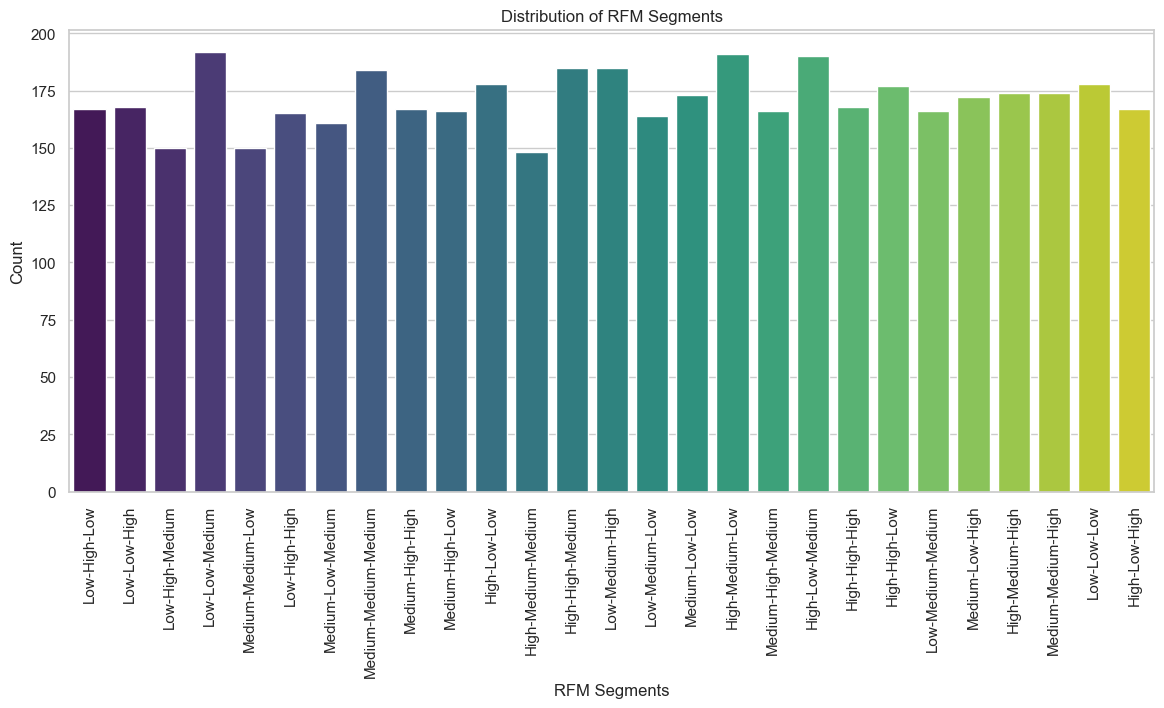

In [57]:
# Define RFM score bins (you can customize the thresholds)
rfm['R_score'] = pd.qcut(rfm['recency'], 3, labels=['High', 'Medium', 'Low'])
rfm['F_score'] = pd.qcut(rfm['frequency'], 3, labels=['Low', 'Medium', 'High'])
rfm['M_score'] = pd.qcut(rfm['monetary'], 3, labels=['Low', 'Medium', 'High'])

# Create Segment based on combined RFM scores
rfm['Segment'] = rfm['R_score'].astype(str) + '-' + rfm['F_score'].astype(str) + '-' + rfm['M_score'].astype(str)

# Visualize RFM segments using a countplot
plt.figure(figsize=(14, 6))
sns.countplot(data=rfm, x='Segment', palette='viridis')
plt.xticks(rotation=90)
plt.title('Distribution of RFM Segments')
plt.xlabel('RFM Segments')
plt.ylabel('Count')
plt.show()